![Judge Research](images/judgeresearch.png)
# Feature Data Tutorial

# Usage

This Judge Research interface can be run locally, on your own laptop, desktop, or server; additionally, it can be run in the cloud using a binderhub service like mybinder or in the Google Cloud.

Hit or click the DOWN ARROW to see the detail of both methods below.

### Build & Launch Your Own

- Install [docker-compose](https://docs.docker.com/compose/install/)
- Launch the container:
```
git clone https://github.com/cyprigroup/jrapitest.git
cd jrapitest
docker-compose up
```
- Open a browser to: [http://127.0.0.1:8888/lab?token=JR](http://127.0.0.1:8888/lab?token=JR)

### Launch in the Cloud

#### MyBinder

- [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/cyprigroup/jrapitest/main?labpath=JudgeResearchNotebooks%2FFeature_Tutorial.ipynb)

## Setup
Import modules for Judge Research, Coinalytix, technical analysis, and plotting tools.

In [1]:
# import classes that handle API connections and parameters
from historical_data import Coinalytix, HDParams
from judgeresearch import JudgeResearch, JRParams

# import classes for data handling & visualization
import json
import plotly.graph_objects as go
import pandas as pd
from datetime import date, datetime, timedelta
import pandas_ta as ta
import time
from watchlist import colors

## Authenticate
Enter your API keys here:

In [2]:
CA_API_KEY = "hHV1QUTclB653YLvFJBJh5Pz0BayF251at64c9x9"
JR_API_KEY = "hHV1QUTclB653YLvFJBJh5Pz0BayF251at64c9x9"

## Configure Assets
Define the parameters for your historical data:

In [3]:
asset = HDParams()
# Set exchange, must be "BINANCE" or ...
asset.exchange = "BINANCE"
# Set asset, currently supports "BTC-USD-SPOT", "ETH-USD-SPOT", ...
asset.ticker = "BTC-USD-SPOT"
# Set start of reporting period in form YYYY-MM-DD HH:MM:SS
# Dates after 2019...? supported
asset.set_start_date("2022-01-01 08:00:00")
# Set reporting interval, currently supports "1d", "1m"...
asset.interval = "1d"
# Set number of reporting periods                    
asset.num_periods = 365

## Collect Data
Setup authentication and fetch historical data from Coinalytix

In [4]:
HD = Coinalytix()
# Set api key
HD.with_api_key(CA_API_KEY)
# Fetch historical data
hddf = HD.fetch_hd(asset)
# Print 5 lines to test
hddf.tail(5)

,StartDate,Open,High,Low,Close,Volume
StartDate,,,,,,
2022-05-20,1.653005e+09,30319.2,30742.0,28730.0,29209.9,11547.49087
2022-05-21,1.653091e+09,29201.0,29645.7,28969.2,29457.7,4175.66491
2022-05-22,1.653178e+09,29445.1,30479.0,29272.7,30295.9,6298.23815
2022-05-23,1.653264e+09,30293.9,30666.0,28938.0,29094.6,13347.91180
2022-05-24,1.653350e+09,29109.1,29322.1,29090.0,29286.9,1419.35005


## Create a Feature Generation Function

In [5]:
# The feature_gen function accepts a pandas dataframe, datetime indexed and should
# return a pandas dataframe, similarly datetime indexed and including a column
# named "feature"

def feature_gen(df):
    ''' Set feature column to 1 or 0 as MACD crosses MACDs '''
    macddf = df.ta.macd(fast=8, slow=21, signal=9, min_periods=None, append=True)
    macddf["macdiff"] = macddf["MACD_8_21_9"] - macddf["MACDs_8_21_9"]
    macddf["feature"] = ['0' if x > 0 else '1' for x in macddf['macdiff']]
    return macddf

# Generate feature dataframe
fdf = feature_gen(hddf)

## Research & Chart
Analyze and chart your dependent and indepenent variables

In [6]:
def ctitle(indicator_name, ticker="BTC-USD", length=100):
    return f"{ticker}: {indicator_name} from {recent_startdate} to {recent_enddate} ({length})"

def recent_bars(df, tf: str = "1y"):
    # All Data: 0, Last Four Years: 0.25, Last Two Years: 0.5, This Year: 1, Last Half Year: 2, Last Quarter: 4
    yearly_divisor = {"all": 0, "10y": 0.1, "5y": 0.2, "4y": 0.25, "3y": 1./3, "2y": 0.5, "1y": 1, "6mo": 2, "3mo": 4}
    yd = yearly_divisor[tf] if tf in yearly_divisor.keys() else 0
    return int(ta.RATE["TRADING_DAYS_PER_YEAR"] / yd) if yd > 0 else df.shape[0]

recent_startdate = hddf.tail(recent_bars(hddf)).index[0]
recent_enddate = hddf.tail(recent_bars(hddf)).index[-1]

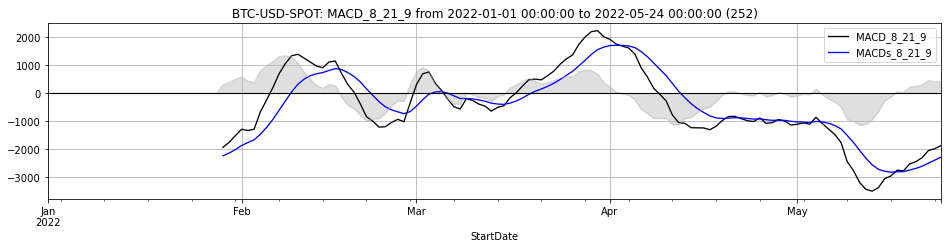

In [7]:
ind_size = (16, 3.25)
fdf[[fdf.columns[0], fdf.columns[2]]].tail(recent_bars(fdf)).plot(figsize=(16, 2), color=colors("BkBl"), linewidth=1.3)
fdf[fdf.columns[1]].tail(recent_bars(fdf)).plot.area(figsize=ind_size, stacked=False, color=["silver"], linewidth=1, title=ctitle(fdf.name, ticker=asset.ticker, length=recent_bars(fdf)), grid=True).axhline(y=0, color="black", lw=1.1)

### Set the constants & default values below as appropriate.

In [8]:
ft_params = JRParams()

# ATTRIBUTE - a string representing the time block of the observation,
# in coordinated universal time following the ISO 8601 standard, in UTC.
# The attribute should be structured as "YYYY-MM-DDTHH:MM:SSZ". For
# the alpha test, if you mistakenly send in objects with a date prior to
# "2019-01-01T00:00:00Z", you won’t receive an error message but earlier observations will be discarded.
ft_params.attribute = "2022-01-01T00:00:00Z" # default value

# DV - a string specifying the dependent variable. Choices during the alpha test are "ETH-USD", 
# "BTC-USD", and "V-BTC-USD", which denotes the volatility of BTC-USD.
ft_params.dv = "BTC-USD"

# MBS - a string specifying the block size of the observation, in minutes. 
# This can be any positive number. For the alpha test, we are currently set to test four hour series,
# so 240 should be the value you set. We will likely include another time frame for the alpha test, 
# and will update this document when we do.
ft_params.mbs= "240"

# FEATURE_NAME - an alphanumeric string for the name of the feature, of length no more than 50 characters. 
# You can name the feature whatever you want.
ft_params.feature_name = "testfeature001"

# VALUE - the most important part! A string with the value of the feature, also of length no more than 50 characters.
# The default value is set here, the feature_gen function will set this variable when generating new feature data.
ft_params.value = "0"    # default value

# IPP - optional, defaults to "last" - what type of interpolation procedure is appropriate for your feature. 
# Values can be either "last" - fill in the missing value with the last observed value - and "zero" - fill in 
# the last value with a 0.
ft_params.ipp = "last"    # default value

## Connect to Judge Research 

In [9]:
JR = JudgeResearch()
JR.with_api_key(JR_API_KEY)

## Format and Submit Historical Features

In [10]:
features = JR.craft_features(ft_params, fdf)
payload = JR.format_payload(features)
submit = JR.submit_feature(payload)

# Print result
print(submit)

<Response [200]>


## Live Feature Calculation and Submission

The code below calculates in intented for the live submission of feature data.  Each data point is submitted three times.

When invoked, a first "safety" guess is calculated and submitted to ensure it is recorded well before the feature submission deadline.

The second and third submissions are send on user-configurable intervals calculated by percentage of time remaining before the close of the window.  For example, if the script is run 10 minutes before the close of a window with "firstdelay" set to 0.50 and the seconddelay set to "0.90" the execution would happen as follows:

T-00:10 Initial Submission
T-00:05 Second Submission
T-00:09 Last Submission
T-00:00 Feature Submission Deadline

### Convenience Functions

In [11]:
def fcs(asset, params):
    """ fetch, calculate, and submit once """
    hddf = HD.fetch_hd(asset)
    fdf = feature_gen(hddf)
    features = JR.craft_features(params, fdf)
    payload = JR.format_payload(features)
    submit = JR.submit_feature(payload)
    return submit
    
def live_fcs(asset, params, firstdelay, seconddelay):
        """
        calculate and submit feature data 3 times, throttled by percentage
        of time remaining until end of widow
        
        first submission = immediate
        second submission = % of remaining time in window ex. .30 = 3 minutes of 10 remaining
        last submission = % of remaining time in window ex, .90 = 9 of 10 remaining
        """
        
        # determine current time
        now = datetime.now()
        print("Current time: " + now.strftime("%Y-%m-%dT%H:%M:%SZ"))
        
        # determine the upcoming deadline (end of window)
        # FIXME: don't assume windows are anchored to 00:00
        genesis_time = datetime.utcnow().today().replace(microsecond=0, second=0, minute=0, hour=0)
        
        # set deadline anchor time
        deadline = genesis_time
        print("Genesis: " + genesis_time.strftime("%Y-%m-%dT%H:%M:%SZ"))
        
        # create timedelta object based on MBS parameter
        window = timedelta(minutes=int(params.mbs))
        
        # iterate through block times until current time is passed, set deadline
        while now > deadline:
            deadline = deadline + window
            
        print("Next Block End: " + deadline.strftime("%Y-%m-%dT%H:%M:%SZ"))
        
        # calculate time remaining until window close
        remaining = deadline - now
        
        # caculate delays (seconds)
        delay1 = int(remaining.total_seconds() * firstdelay)
        delay2 = int(remaining.total_seconds() * seconddelay) - delay1
        
        # submit immediately
        s1 = fcs(asset, ft_params)
        print("First submission at " + datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ"))
        print(s1)
        
        # sleep, recalculate, and send agin
        time.sleep(delay1)
        s2 = fcs(asset, ft_params)
        print("Second submission at " + datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ"))
        print(s2)
        
        # sleep, recalculate, and send final
        time.sleep(delay2)
        s3 = fcs(asset, ft_params)
        print("Final submission at " + datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ"))        
        print(s3)

In [ ]:
live_fcs(asset, ft_params, .50, .90)

Current time: 2022-05-24T04:03:27Z
Genesis: 2022-05-24T00:00:00Z
Next Block End: 2022-05-24T08:00:00Z
First submission at 2022-05-24T04:03:32Z
<Response [200]>
